In [1]:
# general imports
import numpy as np
from typing import List, Optional, Tuple, Dict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from bioinfokit.analys import stat
import itertools
import math
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score
from causalinference import CausalModel
import unidecode
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML
from sklearn import preprocessing
from statsmodels.formula.api import ols

In [2]:
def average(lst):
    """
    A function that finds the average of a list of items.
    """
    return sum(lst) / len(lst)

def removeNanValues(column, df) -> None:
    """
    A function that remove NaN values from a specific row in a dataframe.
    
    :param column: The column to be considered.
    :param character: The dataframe to be used.
    """
    # replace any empty strings in the long name column with np.nan objects
    df[column].replace('', np.nan, inplace=True)
    df[column].replace(r'^\s*$', np.nan, regex=True)
    # drop the null values
    df.dropna(subset=[column], inplace=True)

def isDarkerSkin(value):
    if value == 'Darker skin tone':
        return True
    else: return False
    

def isDarkerSkinBinary(value):
    if value == 'Darker skin tone':
        return 1
    else: return 0
    
def isPhysicalPosition(value):
    if value == 'physical':
        return 1
    else: return 0
    

def isTacticalPosition(value):
    if value == 'tactical':
        return 1
    else: return 0
    
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

### RQ2

#### Getting reddit data

In [3]:
reddit_df = pd.read_csv('data/temp/processed_data/reddit/reddit_player_sentiment.csv')
reddit_df.head()

title  \
0  Match Thread: Chelsea vs Burnley [English Prem...   
1  Match Thread: Chelsea vs Burnley [English Prem...   
2  Match Thread: Chelsea vs Burnley [English Prem...   
3  Match Thread: Chelsea vs Burnley [English Prem...   
4  Match Thread: Chelsea vs Burnley [English Prem...   

                                             comment  score team_home  \
0  Emotions are running high so a lot of comments...      2   Chelsea   
1  What is the procedure to overcome the depressi...      1   Chelsea   
2  I have Tom Heaton in goal on my fantasy team s...      1   Chelsea   
3  instaed of waving hands like fucking retard  o...     -1   Chelsea   
4                    there is a guy whose called Mee     -2   Chelsea   

  team_away   created_utc              author             competition season  \
0   Burnley  1.502550e+09                 NaN  English Premier League  17/18   
1   Burnley  1.502552e+09             Afrotik  English Premier League  17/18   
2   Burnley  1.502550e+09           F34rcr4ds  English Premier League  17/18   
3   Burnley  1.502551e+09               Ratay  English Premier League  17/18   
4   Burnley  1.502551e+09  uninterestingBrick  English Premier League  17/18   

   person_name  ...                                       player_image  \
0       Defour  ...  https://cdn.soccerwiki.org/images/player/8948.png   
1        Vokes  ...  https://cdn.soccerwiki.org/images/player/22285...   
2   Tom Heaton  ...  https://cdn.soccerwiki.org/images/player/13566...   
3  Gary Cahill  ...    https://cdn.soccerwiki.org/images/player/36.png   
4          Mee  ...  https://cdn.soccerwiki.org/images/player/45936...   

  player_soccer_wiki_color  player_position player_position_description  \
0                    White      DM(C),M(RC)          GENERAL MIDFIELDER   
1                    White             F(C)                  TARGET MAN   
2                    White               GK                      KEEPER   
3                    White             D(C)                     STOPPER   
4                    White             D(C)            GENERAL DEFENDER   

  player_rating player_age player_whoscored_position  match_score  \
0          7.98         34                        MC        3-Feb   
1          9.00         32                        FW        3-Feb   
2          6.74         36                        GK        3-Feb   
3          5.31         36                        DC        3-Feb   
4          6.88         32                        DC        3-Feb   

   vader_sentiment_score vader_sentiment_label  
0                -0.0493               Neutral  
1                -0.5719              Negative  
2                 0.7783              Positive  
3                 0.0790               Neutral  
4                 0.0000               Neutral  

[5 rows x 23 columns]

#### Summary statistics

In [4]:
positive = reddit_df.loc[reddit_df.vader_sentiment_label == 'Positive']
print('Positive comments')
print(len(positive))

negative = reddit_df.loc[reddit_df.vader_sentiment_label == 'Negative']
print('Negative comments')
print(len(negative))
df1 = positive.groupby(['player_id'])['player_id'].count().reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(5)
print(df1)
print(reddit_df.loc[reddit_df.player_id == 58616]['player_long_name'].head(1))

df2 = negative.groupby(['player_id'])['player_id'].count().reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(5)
print(df2)
print(reddit_df.loc[reddit_df.player_id == 1933]['player_long_name'].head(1))

Positive comments
3885
Negative comments
2577
     player_id  count
123      58616    199
161      84384    159
10        1933    159
79       44201    154
179      99607    150
173    Riyad Mahrez
Name: player_long_name, dtype: object
     player_id  count
10        1933    150
116      58616    132
153      84384    131
90       47159    113
71       44201    110
512    Ashley Young
Name: player_long_name, dtype: object


In [5]:
group_lighter = ['White','Pale','Olive']
group_darker = ['Black','Brown','Dark brown']
reddit_df['grouped_skin_color'] = ['Lighter skin tone' if skin_color in group_lighter 
                                     else ('Darker skin tone' if skin_color in group_darker else '') 
                                     for skin_color in reddit_df.player_soccer_wiki_color]

removeNanValues('grouped_skin_color', reddit_df)
    
physical_positions = ['TARGET MAN','FINISHER','WINGBACK','GENERAL FORWARD','WINGER']
tactical_positions = ['BOX-TO-BOX MIDFIELDER','BALL-WINNING MIDFIELDER','PLAYMAKER','KEEPER','GENERAL MIDFIELDER','DEEP-LYING PLAYMAKER']

reddit_df['player_position_group'] = ['physical' if player_position in physical_positions 
                                     else ('tactical' if player_position in tactical_positions else '') 
                                     for player_position in reddit_df.player_position_description]

removeNanValues('player_position_group', reddit_df)

In [6]:
reddit_df['is_darker_skin'] = reddit_df.grouped_skin_color.apply(isDarkerSkin)
reddit_df['is_darker_skin_binary'] = reddit_df.grouped_skin_color.apply(isDarkerSkinBinary)

reddit_df['is_physical_position'] = reddit_df.player_position_group.apply(isPhysicalPosition)
reddit_df['is_tactical_position'] = reddit_df.player_position_group.apply(isTacticalPosition)

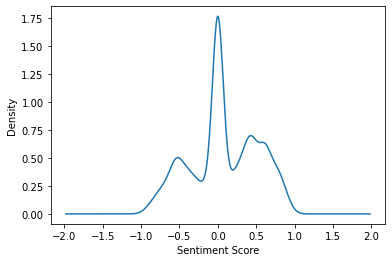

In [7]:
reddit_df['vader_sentiment_score'].plot(kind='kde')
plt.xlabel('Sentiment Score')
plt.show()

#### Preparing players dataset.

In [4]:
def get_players_df(reddit_data):
    players_df = pd.DataFrame(columns=['id', 'skin_color', 'is_darker_skin', 'is_darker_skin_binary','age', 'rating_average',
                                   'visibility', 'player_position_group','is_physical_position', 'is_tactical_position',
                                  'prop_positive', 'prop_negative', 'average_negativity', 'average_positivity', 'sentiment_score'])
    
    player_ids = reddit_data.player_id.unique()
    total = len(reddit_data)
    index = 0
    for player_id in player_ids:
        avg_negative = 0
        avg_positive = 0
        quartile_negative = 0
        quartile_positive = 0
        data = reddit_data.loc[reddit_data.player_id == player_id]
        positive_data = data.loc[data.vader_sentiment_label == 'Positive']['vader_sentiment_score'].values
        negative_data = data.loc[data.vader_sentiment_label == 'Negative']['vader_sentiment_score'].values
        
        if (len(positive_data)):
            avg_positive = average(positive_data)
            quartile_positive = data.loc[data.vader_sentiment_label == 'Positive']['vader_sentiment_score'].quantile(0.9)
            
        if (len(negative_data)):
            avg_negative = average(negative_data)
            quartile_negative = data.loc[data.vader_sentiment_label == 'Negative']['vader_sentiment_score'].quantile(0.1)
            
        prop_positive = len(data.loc[data.vader_sentiment_label == 'Positive']) / len(data)
        prop_negative = len(data.loc[data.vader_sentiment_label == 'Negative']) / len(data)
        
        
        new_data = pd.DataFrame({'id': player_id, 
                                 'skin_color': data.grouped_skin_color.iloc[0],
                                 'is_darker_skin': data.is_darker_skin.iloc[0],
                                 'is_darker_skin_binary': data.is_darker_skin_binary.iloc[0],
                                 'age': data.player_age.iloc[0],
                                 'rating_average': average(data.player_rating.values),
                                 'number_comments': len(data),
                                 'visibility': len(data)/total,
                                 'player_position_group': data.player_position_group.iloc[0],
                                 'is_physical_position': data.is_physical_position.iloc[0],
                                 'is_tactical_position': data.is_tactical_position.iloc[0],
                                'quartile_positive': quartile_positive,
                                'quartile_negative': quartile_negative},
                                index = [index])
        players_df = pd.concat([players_df, new_data])
        index = index + 1
    
    players_df['id'] =  pd.to_numeric(players_df['id'])
    players_df['rating_average'] = pd.to_numeric(players_df['rating_average'])
    players_df['age'] = pd.to_numeric(players_df['age'])
    players_df['visibility'] = pd.to_numeric(players_df['visibility'])
    players_df['quartile_positive'] = pd.to_numeric(players_df['quartile_positive'])
    players_df['quartile_negative'] = pd.to_numeric(players_df['quartile_negative'])
    players_df['is_darker_skin_binary'] = pd.to_numeric(players_df['is_darker_skin_binary'])
    players_df['is_physical_position'] = pd.to_numeric(players_df['is_physical_position'])
    players_df['is_tactical_position'] = pd.to_numeric(players_df['is_tactical_position'])
    players_df['number_comments'] = players_df['number_comments'].astype(int)
        
    players_df['is_darker_skin'] = players_df['is_darker_skin'].astype('bool')
    
    return players_df

In [9]:
df = get_players_df(reddit_df)
df.head()

id         skin_color  is_darker_skin  is_darker_skin_binary  age  \
0   8948  Lighter skin tone           False                      0   34   
1  22285  Lighter skin tone           False                      0   32   
2  13566  Lighter skin tone           False                      0   36   
3  64132   Darker skin tone            True                      1   26   
4  52519   Darker skin tone            True                      1   29   

   rating_average  visibility player_position_group  is_physical_position  \
0        7.275000    0.000416              tactical                     0   
1        6.813333    0.000624              physical                     1   
2        6.984286    0.000728              tactical                     0   
3        6.974640    0.041931              physical                     1   
4        7.457381    0.004370              tactical                     0   

   is_tactical_position  prop_positive  prop_negative  average_negativity  \
0                     1       0.750000       0.000000            0.000000   
1                     0       0.500000       0.166667           -0.571900   
2                     1       0.428571       0.000000            0.000000   
3                     0       0.339950       0.166253           -0.604975   
4                     1       0.285714       0.214286           -0.640767   

   average_positivity sentiment_score  number_comments  median  \
0            0.661500             NaN                4  0.6247   
1            0.625167             NaN                6  0.2294   
2            0.749900             NaN                7  0.1027   
3            0.638032             NaN              403  0.0000   
4            0.588008             NaN               42  0.0000   

   quartile_positive  quartile_negative  
0            0.72218             0.0000  
1            0.71438            -0.5719  
2            0.78814             0.0000  
3            0.87344            -0.7983  
4            0.70015            -0.7602

In [10]:
print('Players with darker skin tone playing in physical positions',len(df.loc[(df.is_darker_skin == True) & (df.player_position_group == 'physical')]))
print('Players with darker skin tone playing in tactical positions',len(df.loc[(df.is_darker_skin == True) & (df.player_position_group == 'tactical')]))

print('Players with lighter skin tone playing in physical positions',len(df.loc[(df.is_darker_skin == False) & (df.player_position_group == 'physical')]))
print('Players with lighter skin tone playing in tactical positions', len(df.loc[(df.is_darker_skin == False) & (df.player_position_group == 'tactical')]))

df.to_csv('data/analysis/players_reddit.csv')

Players with darker skin tone playing in physical positions 34
Players with darker skin tone playing in tactical positions 15
Players with lighter skin tone playing in physical positions 46
Players with lighter skin tone playing in tactical positions 57


#### Correlation between age and quartile negative/positive

In [11]:
from scipy.stats import pearsonr

print(pearsonr(df['age'], df['quartile_negative']))
print(pearsonr(df['age'], df['quartile_positive']))

(0.07996978756052983, 0.3273999252053323)
(-0.12182006449322394, 0.1348949951385188)


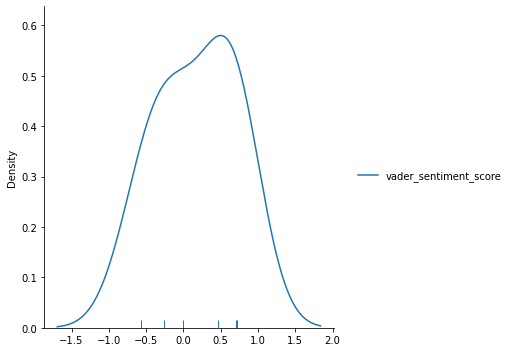

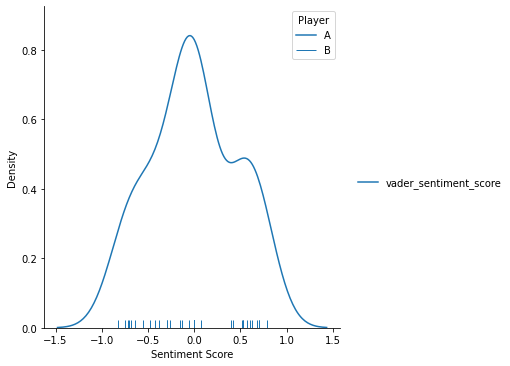

In [12]:
unique_vals = reddit_df['player_id'].unique()  # [0, 1, 2]

# Sort the dataframe by target
# Use a list comprehension to create list of sliced dataframes
targets = [reddit_df.loc[reddit_df.player_id == val] for val in unique_vals[:5]]

# Iterate through list and plot the sliced dataframe
for target in targets:
    sns.displot(target[['vader_sentiment_score']], rug=True, kind="kde")
    
plt.legend(['A', 'B', 'C', 'D', 'E'], title='Player', fontsize=10)    
plt.xlabel('Sentiment Score')
plt.show()

#### Normalization of variables

In [13]:
df['quartile_negative'] = NormalizeData(df.quartile_negative.values)
df['quartile_positive'] = NormalizeData(df.quartile_positive.values)

In [14]:
df['age'] = NormalizeData(df.age.values)
df['rating_average'] = NormalizeData(df.rating_average.values)
df['visibility'] = np.log2(df.visibility)

#### Linear Regression Models

In [15]:
reg = ols("quartile_negative ~ is_darker_skin_binary + age + rating_average + visibility + is_physical_position", data = df).fit()
stargazer = Stargazer([reg])

file = open("data/analysis/reddit_quartile_negative.html","w")
file.write(stargazer.render_latex())
file.close()

In [17]:
reg = ols("quartile_positive ~ is_darker_skin_binary + age + rating_average + visibility + is_physical_position", data = df).fit()
stargazer = Stargazer([reg])

file = open("data/analysis/reddit_quartile_positive.html","w")
file.write(stargazer.render_latex())
file.close()

#### Multicollinearity

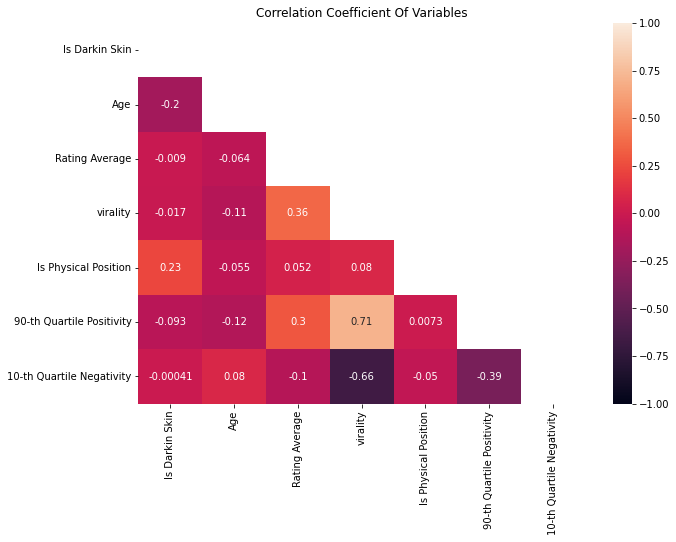

In [18]:
data = df[['is_darker_skin_binary','age','rating_average', 'visibility', 'is_physical_position','quartile_positive','quartile_negative']]

# set figure size
plt.figure(figsize=(10,7))

data = data.rename(columns={'is_darker_skin_binary': 'Is Darkin Skin', 'age': 'Age','rating_average':'Rating Average',
                          'is_physical_position':'Is Physical Position', 'visibility': 'virality', 
                            'quartile_negative': '10-th Quartile Negativity', 'quartile_positive': '90-th Quartile Positivity'})
# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(data.corr(), dtype=bool))

# generate heatmap
sns.heatmap(data.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficient Of Variables')
plt.show()

### RQ3

#### Getting and preparing the data

In [5]:
reddit_df = pd.read_csv('data/temp/processed_data/reddit/reddit_supersenses.csv')

group_lighter = ['White','Pale','Olive']
group_darker = ['Black','Brown','Dark brown']
reddit_df['grouped_skin_color'] = ['Lighter skin tone' if skin_color in group_lighter 
                                     else ('Darker skin tone' if skin_color in group_darker else '') 
                                     for skin_color in reddit_df.player_soccer_wiki_color]

removeNanValues('grouped_skin_color', reddit_df)
    
physical_positions = ['TARGET MAN','FINISHER','WINGBACK','GENERAL FORWARD','WINGER']
tactical_positions = ['BOX-TO-BOX MIDFIELDER','BALL-WINNING MIDFIELDER','PLAYMAKER','KEEPER','GENERAL MIDFIELDER','DEEP-LYING PLAYMAKER']

reddit_df['player_position_group'] = ['physical' if player_position in physical_positions 
                                     else ('tactical' if player_position in tactical_positions else '') 
                                     for player_position in reddit_df.player_position_description]

removeNanValues('player_position_group', reddit_df)

reddit_df['is_darker_skin'] = reddit_df.grouped_skin_color.apply(isDarkerSkin)
reddit_df['is_darker_skin_binary'] = reddit_df.grouped_skin_color.apply(isDarkerSkinBinary)

reddit_df['is_physical_position'] = reddit_df.player_position_group.apply(isPhysicalPosition)
reddit_df['is_tactical_position'] = reddit_df.player_position_group.apply(isTacticalPosition)

In [6]:
reddit_df_positive = reddit_df.loc[reddit_df.vader_sentiment_label == 'Positive']
reddit_df_positive.reset_index(drop=True, inplace=True)
reddit_df_negative = reddit_df.loc[reddit_df.vader_sentiment_label == 'Negative']
reddit_df_negative.reset_index(drop=True, inplace=True)

physical_categories = ['TEMPORAL', 'BODY']
tactical_categories = ['BEHAVIOR', 'MIND']

#### Define the category of the comment

In [7]:
for index, row2 in reddit_df.iterrows():
    physical_comments = 0
    tactical_comments = 0
    category_0, category_1, category_2, category_3 = str(row2.category_0).strip(), str(row2.category_1).strip(),str(row2.category_2).strip(), str(row2.category_3).strip()
    if category_0 in physical_categories or category_1 in physical_categories or category_2 in physical_categories or category_3 in physical_categories:
        physical_comments += 1
    if category_0 in tactical_categories or category_1 in tactical_categories or category_2 in tactical_categories or category_3 in tactical_categories:
        tactical_comments += 1
    
    reddit_df.loc[index, 'comment_category'] = 'Physical' if physical_comments > tactical_comments else 'Tactical'

#### Get Has Physical/Tactical Comments and Total Physical/Tactical Comments

In [28]:
players_df = get_players_df(reddit_df)

In [29]:
def get_info_comments(players_df, reddit_df):
    for index, row in players_df.iterrows():
        #get the list of comments targeting the player
        comments = reddit_df.loc[reddit_df.player_id == row.id]
        physical_comments = 0
        tactical_comments = 0
        for index2, row2 in comments.iterrows():
            comment_category = str(row2.comment_category)
            if comment_category == 'Physical':
                physical_comments += 1
            else:
                tactical_comments += 1
        
        players_df.loc[index, 'has_physical_comments'] = 1 if physical_comments > 0 else 0
        players_df.loc[index, 'has_tactical_comments'] = 1 if tactical_comments > 0 else 0
        players_df.loc[index, 'total_physical_comments'] = physical_comments 
        players_df.loc[index, 'total_tactical_comments'] = tactical_comments 
    return players_df

In [30]:
df = get_info_comments(players_df, reddit_df)

df['age'] = NormalizeData(df.age.values)
df['rating_average'] = NormalizeData(df.rating_average.values)
df['total_physical_comments'] = NormalizeData(df.total_physical_comments.values)
df['total_tactical_comments'] = NormalizeData(df.total_tactical_comments.values)
df['visibility'] = np.log2(df.visibility)

#### Multicollinearity

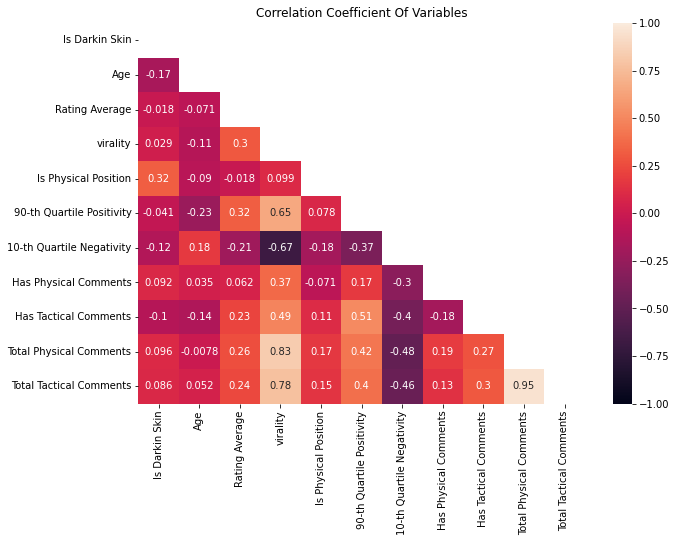

In [31]:
data = df[['is_darker_skin_binary','age','rating_average', 'visibility', 'is_physical_position','quartile_positive','quartile_negative','has_physical_comments','has_tactical_comments','total_physical_comments','total_tactical_comments']]

# set figure size
plt.figure(figsize=(10,7))

data = data.rename(columns={'is_darker_skin_binary': 'Is Darkin Skin', 'age': 'Age','rating_average':'Rating Average',
                          'is_physical_position':'Is Physical Position', 'visibility': 'virality', 
                            'quartile_negative': '10-th Quartile Negativity', 'quartile_positive': '90-th Quartile Positivity',
                           'has_physical_comments':'Has Physical Comments','has_tactical_comments':'Has Tactical Comments',
                           'total_physical_comments':'Total Physical Comments','total_tactical_comments':'Total Tactical Comments'})
# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(data.corr(), dtype=bool))

# generate heatmap
sns.heatmap(data.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficient Of Variables')
plt.show()

#### Investigating the relationship between sentiment score and category group

In [32]:
data1 = reddit_df.loc[(reddit_df.comment_category == 'Physical')]['vader_sentiment_score'] 
data2 = reddit_df.loc[(reddit_df.comment_category == 'Tactical')]['vader_sentiment_score'] 

In [33]:
sns.boxplot(y='vader_sentiment_score', x='comment_category', 
                 data=reddit_df, 
                 palette="colorblind").set(
    xlabel='Category', 
    ylabel='Sentiment Score'
)

[Text(0.5, 0, 'Category'), Text(0, 0.5, 'Sentiment Score')]

In [34]:
from bioinfokit.analys import stat
res = stat()
res.anova_stat(df=reddit_df, res_var='value', anova_model='vader_sentiment_score ~ C(comment_category)')
res.anova_summary

df      sum_sq   mean_sq         F    PR(>F)
C(comment_category)     1.0    0.309529  0.309529  1.193771  0.274705
Residual             1947.0  504.831182  0.259287       NaN       NaN

#### Linear regression models

In [35]:
reg = ols("has_physical_comments ~ is_darker_skin_binary + visibility + is_physical_position", data = df).fit(cov_type = 'HC3')
stargazer = Stargazer([reg])

file = open("data/analysis/reddit_all_physical.html","w")
file.write(stargazer.render_latex())
file.close()

reg = ols("has_tactical_comments ~ is_darker_skin_binary + visibility + is_physical_position", data = df).fit(cov_type = 'HC3')
stargazer = Stargazer([reg])

file = open("data/analysis/reddit_all_tactical.html","w")
file.write(stargazer.render_latex())
file.close()

In [36]:
data_physical = df.loc[df.has_physical_comments == 1]
data_tactical = df.loc[df.has_tactical_comments == 1]

In [37]:
reg = ols("total_physical_comments ~ is_darker_skin_binary + visibility + is_physical_position", data = data_physical).fit(cov_type = 'HC3')
stargazer = Stargazer([reg])

file = open("data/analysis/reddit_all_physical_prop.html","w")
file.write(stargazer.render_latex())
file.close()

reg = ols("total_tactical_comments ~ is_darker_skin_binary + visibility + is_physical_position", data = data_tactical).fit(cov_type = 'HC3')
stargazer = Stargazer([reg])

file = open("data/analysis/reddit_all_tactical_prop.html","w")
file.write(stargazer.render_latex())
file.close()